In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re
from ast import literal_eval
import seaborn as sns
import decimal

In [2]:
import sys  
sys.path.insert(0, '../scripts')

from D_plot_specificity_matrix_utils import (peptide_per_clonotype_by_gem_size,
                                             multiple_peptides_per_gem_w_filtering,
                                             calc_binding_concordance,
                                             epitope_sorter_index,
                                             peptides_per_gem)

In [3]:
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

In [4]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,'HLA_cd8': HLA_cd8_converter} #

In [5]:
def notnan(x):
    return x == x

In [6]:
def get_multiplets(df):
    #tmp = df[idx1 & idx2]
    dct = df.groupby(['ct','peptide_HLA']).gem.count() > 1
    idx = df.set_index(['ct','peptide_HLA']).index.map(dct)
    return idx.fillna(False)

In [7]:
def plot_specificity(title, df, max_gems, save=True):
    # Sort
    df.ct = df.ct.astype(int).astype(str)
    df.sort_values(by=['epitope_rank','gems_per_specificity','binding_concordance'], #,'ct'
                       ascending=[True, False, False], inplace=True) #, True

    # devide GEMs by max concordance and outliers
    dct = df.groupby('ct').binding_concordance.max()
    df['max_conc'] = df.ct.map(dct)
    idx = df.binding_concordance == df.max_conc

    def modify_legend(h,l):
        flag = False
        labels = []
        handles = []
        for e, le in enumerate(l):
            if flag:
                #if (int(le) % 10 == 0) | (le == '1'):
                labels.append(le)
                handles.append(h[e])
            if le == 'gems_per_specificity':
                flag = True
                
        n = len(labels)
        
        handles = [handles[int(i)] for i in np.linspace(0,n-1,5)] #[0, int(n/2),n-1]
        labels = [labels[int(i)] for i in np.linspace(0,n-1,5)] #[0, int(n/2),n-1]
        return handles, labels
    
    # Style
    # https://seaborn.pydata.org/generated/seaborn.axes_style.html
    sns.set_style('ticks', {'axes.edgecolor': '0', #'axes.facecolor':'lightgrey',
                            'xtick.color': '0',
                            'ytick.color': '0'})
    sns.set_context("paper",font_scale=2)
    
    fig_height = int(df.peptide_HLA.nunique() * 0.4)
    fig = plt.figure(figsize=(20, fig_height)) #6
    sns.scatterplot(data=df[idx], x='ct', y='peptide_HLA',
                    size='gems_per_specificity', sizes=(10,1000), size_norm=(1,max_gems),
                    hue='binding_concordance', palette='viridis_r', hue_norm=(0,1),
                    legend='full', linewidth=0)
    sns.scatterplot(data=df[~idx], x='ct', y='peptide_HLA',
                    size='gems_per_specificity', sizes=(10,1000), size_norm=(1,max_gems),
                    hue='binding_concordance', palette='viridis_r', hue_norm=(0,1),
                    legend=False, linewidth=0)
    ax = plt.gca()
    sm = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap='viridis_r') # hack for cbar
    sm.set_array([]) # hack for cbar
    #fig.colorbar(sm, ax=ax, pad=0.01)
    #fig.colorbar(sm, ax=ax, orientation='horizontal', label='Binding Concordance', fraction=0.06, shrink=0.5) #https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.colorbar.html
    fig.colorbar(sm, ax=ax, orientation='horizontal', label='Binding Concordance', fraction=0.06*6/fig_height, pad=0.15*6/fig_height) #https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.colorbar.html


    h,l = ax.get_legend_handles_labels()
    h,l = modify_legend(h,l)
    ax.legend(h, l, bbox_to_anchor=(0.5, -0.5*6/fig_height), loc=9, frameon=False, title='GEMs', ncol=len(l)) #-0.5

    #plt.title('%d clonotypes (%d GEMs)' %(df.ct.nunique(), df.gem.nunique()))
    plt.xlabel('%d clonotypes (across %d GEMs)' %(df.ct.nunique(), df.gem.nunique()))
    #plt.xlabel('')
    plt.ylabel('')
    #ax.yaxis.grid(True)

    sns.despine(bottom=False, trim=True, offset={'left':-30})
    ax.set_xticks([])
    ax.set_xticklabels([])
    if save:
        plt.savefig(title, bbox_inches='tight', dpi=300)
    plt.show()

# Input

In [8]:
DIR = '../experiments/exp10x/run1/'

In [9]:
OPT_THR = DIR + 'cat/eval_clonotypes/threshold/opt.csv'

In [10]:
VALID = DIR + 'cat/eval_clonotypes/valid_ct.csv'

In [11]:
ICON = DIR + 'cat/eval_clonotypes/valid_ct.icon.csv'

In [12]:
#GEX = '../experiments/exp13/run1_archive/tcr/usable_gems.txt'
#GEX = DIR + 'cat/eval_clonotypes/threshold/gex.txt'

In [12]:
filter_set = '10x_icon_comb' #'indv'
AUC = DIR + 'cat/similarity_assessment/plt_df/m.%s.auc.csv' %filter_set

# Load

In [13]:
auc_df = pd.read_csv(AUC)

In [14]:
#gex = pd.read_csv(GEX, header=None, names=['gem'])
#gex = np.loadtxt(GEX, dtype='str')

In [15]:
opt_thr = pd.read_csv(OPT_THR, index_col=0, header=None, names=['thr']).thr.dropna()
#opt_thr.delta_umi_mhc = 1
#opt_thr.delta_umi_TRA = 0
#opt_thr.delta_umi_TRB = 0
opt_thr

umi_count_mhc    5.000000
delta_umi_mhc    1.168364
umi_count_TRA    1.000000
delta_umi_TRA    0.757858
umi_count_TRB    0.000000
delta_umi_TRB    0.757858
Name: thr, dtype: float64

In [16]:
df_icon = pd.read_csv(ICON, converters=converters, low_memory=False)

In [17]:
os1 = pd.read_csv(VALID, converters=converters, low_memory=False)

In [18]:
os1.fillna({'umi_count_mhc':0, 'delta_umi_mhc':0, 'umi_count_mhc_rel':0,
           'umi_count_cd8':0, 'delta_umi_cd8':0,
           'umi_count_TRA':0, 'delta_umi_TRA':0,
           'umi_count_TRB':0, 'delta_umi_TRB':0,
           'cdr3_TRA':'','cdr3_TRB':''}, inplace=True)

In [19]:
df = os1.copy() # 10x

In [20]:
#df['gex'] = df.gem.isin(gex)
df['gex'] = df.gem.isin([]) # 10x

In [27]:
# ICON specific
dct = df.set_index('peptide_HLA').epitope_rank.to_dict()

df_icon['peptide_HLA_atrap'] = df_icon.peptide_HLA
df_icon['peptide_HLA'] = df_icon.peptide_HLA_icon
df_icon['epitope_rank'] = df_icon.peptide_HLA.map(dct)

# Redefine clonotypes
clono = df_icon.groupby(['beta_cdr3','beta_v_gene','beta_j_gene','alpha_cdr3','alpha_v_gene','alpha_j_gene']).size().sort_values(ascending=False).to_frame()
clono['ct'] = np.arange(1, len(clono)+1)
df_icon['ct_atrap'] = df_icon.ct
df_icon.ct = df_icon.set_index(['beta_cdr3','beta_v_gene','beta_j_gene','alpha_cdr3','alpha_v_gene','alpha_j_gene']).index.map(clono.ct)

In [28]:
# ICON specific
df_icon.pep_match = df_icon.apply(lambda row: row.peptide_HLA_icon == row.ct_pep if notnan(row.ct_pep) else np.nan, axis=1)

# Reduction in GEMs and CTs when filtering

In [29]:
df.single_barcode_mhc = np.where(df.single_barcode_mhc, 'pMHC singlet','pMHC multiplet')

In [30]:
df['clonotype_multiplet'] = df.ct.map(df.groupby('ct').size() > 1)

In [31]:
df_icon.single_barcode_mhc = np.where(df_icon.single_barcode_mhc, 'pMHC singlet','pMHC multiplet')
df_icon['clonotype_multiplet'] = df_icon.ct.map(df_icon.groupby('ct').size() > 1)

In [32]:
total_gems = len(df.gem.unique())
total_cts = len(df.ct.unique())
#total_acc = round(df.train_label.sum() / len(df.train_label.dropna()) * 100, 1)
total_acc = round(df.pep_match.sum() / len(df.pep_match.dropna()) * 100, 1)
total_conc = round(calc_binding_concordance(df[df.clonotype_multiplet].copy(), 'ct').binding_concordance.mean() * 100, 1)

In [33]:
idx1 = eval(' & '.join([f'(df.{k} >= {abs(v)})' for k,v in opt_thr.items()]))

idx2 = df.hto_global_class == 'Singlet'

idx3 = df.apply(lambda row: row.peptide_HLA.split()[-1] in row.HLA_cd8 if (notnan(row.peptide_HLA) & notnan(row.HLA_cd8)) else False, axis=1)

idx4 = df['exclude_single-chain_TCRs']

idx5 = get_multiplets(df)

In [34]:
idx6 = df.cell_flag

In [35]:
idx8 = df.gex

In [36]:
idx9 = ~df_icon.gem.isna() #~df.gem_icon.isna()
idx10 = df_icon.apply(lambda row: row.HLA_mhc_icon in row.HLA_cd8, axis=1)
idx11 = df_icon.v_alpha_match & df_icon.v_beta_match & df_icon.j_alpha_match & df_icon.j_beta_match

In [37]:
filter_set

'10x_icon_comb'

In [192]:
# 10x filtering
#filter_set = filter_set + '_indv'
filterings = [idx1,
              idx3,
              idx4,
              idx5,
              idx6] #,idx9, idx10, idx11]
labels = ['optimal threshold',
          'matching HLA',
          'complete TCRs',
          'specificity multiplets',
          'is cell'] #, 'icon','icon matching HLA','icon complete TCRs']
palette = ['grey','yellow','#ffffcc','#7fcdbb','#41b6c4','#2c7fb8'] #,'#d6b4fc','violet','#490648'] #'#490648' #dark violet '#34013f'

In [193]:
# ICON filtering
#filter_set = 'icon_indv'
filterings_icon = [idx9, idx10] #, idx11
labels_icon = ['icon','icon matching HLA'] #,'icon complete TCRs'
palette_icon = ['#d6b4fc','violet'] #,'#490648' #'#490648' #dark violet '#34013f'

In [38]:
# 10x filtering
#filter_set = '10x_icon_comb'
filterings = [idx1,
              (idx1 & idx3),
              (idx1 & idx3 & idx4),
              (idx1 & idx3 & idx4 & idx5),
              (idx1 & idx3 & idx4 & idx5 & idx6)] #, idx9, (idx9 & idx10), (idx9 & idx10 & idx11)]
labels = ['optimal threshold',
          'matching HLA',
          'complete TCRs',
          'specificity multiplets',
          'is cell'] #, 'icon','icon matching HLA','icon complete TCRs']
palette = ['grey','yellow','#ffffcc','#7fcdbb','#41b6c4','#2c7fb8'] #,'#d6b4fc','violet','#490648']

In [39]:
# ICON filtering
#filter_set = 'ICON_comb'
filterings_icon = [idx9, (idx9 & idx10)] #, (idx9 & idx10 & idx11)]
labels_icon = ['icon','icon matching HLA'] #,'icon complete TCRs']
palette_icon = ['#d6b4fc','violet'] #,'#490648']

# Main

In [40]:
plt_df = pd.DataFrame(columns=['counts','percent','variable','filters'])
plt_df.loc[0,['counts','percent','variable','filters']] = total_gems, 100, 'GEMs', 'total'
plt_df.loc[1,['counts','percent','variable','filters']] = total_cts, 100, 'clonotypes', 'total'
plt_df.loc[2,['counts','percent','variable','filters']] = total_acc, total_acc, 'accuracy', 'total'
plt_df.loc[3,['counts','percent','variable','filters']] = total_conc, total_conc, 'avg. conc.', 'total'

In [41]:
plt_df

,counts,percent,variable,filters
0,181913,100,GEMs,total
1,76627,100,clonotypes,total
2,79.9,79.9,accuracy,total
3,68.6,68.6,avg. conc.,total


### Initializing dataframe for TCR category summary

In [42]:
data = ['total'] + labels + labels_icon # OBS!
binding_category = ['normal','outlier']
tcr_category = ['missing chain','multiple chains','unique chains']

indexes = len(binding_category)*len(tcr_category)*len(data)

# Initiate dataframe
smry = pd.DataFrame(columns=['freq','frac','pos'],index=np.arange(indexes))
smry.index = pd.MultiIndex.from_product([data, binding_category, tcr_category],
                                        names=['data', 'binding_category','tcr_category'])

#### Populating dataframe with summary of total data

In [43]:
tmp = calc_binding_concordance(df.copy(), 'ct')
tmp['binding_category'] = np.where(tmp.binding_concordance > 0.5, 'normal','outlier')

stmp = tmp.groupby(['binding_category','tcr_category']).size().to_frame().rename(columns={0:'freq'})
stmp.loc['normal','frac'] = stmp.loc['normal','freq'].values / stmp.loc['normal','freq'].sum() * 100
stmp.loc['outlier','frac'] = stmp.loc['outlier','freq'].values / stmp.loc['outlier','freq'].sum() * 100
stmp['pos'] = 0

stmp = pd.concat({'total': stmp}, names=['data']) #stmp['data'] = 'total'

smry.loc[stmp.index, ['freq','frac','pos']] = stmp

### Initializing dataframe for pMHC summary

In [44]:
data = ['total'] + labels + labels_icon # OBS!
binding_category = ['normal','outlier']
pmhc_category = ['pMHC multiplet','pMHC singlet']

indexes = len(binding_category)*len(pmhc_category)*len(data)

# Initiate dataframe
pmhc = pd.DataFrame(columns=['freq','frac','pos'], index=np.arange(indexes))
pmhc.index = pd.MultiIndex.from_product([data, binding_category, pmhc_category],
                                        names=['data', 'binding_category','single_barcode_mhc'])


#### Populating dataframe with summary of total data

In [45]:
#pfs = list()
ptmp = tmp.groupby(['binding_category','single_barcode_mhc']).size().to_frame().rename(columns={0:'freq'})

ptmp.loc['normal','frac'] = ptmp.loc['normal','freq'].values / ptmp.loc['normal','freq'].sum() * 100
ptmp.loc['outlier','frac'] = ptmp.loc['outlier','freq'].values / ptmp.loc['outlier','freq'].sum() * 100
ptmp = pd.concat({'total': ptmp}, names=['data']) #ptmp['data'] = 'total'
#pfs.append(pmhc)

pmhc.loc[ptmp.index, ['freq','frac']] = ptmp

In [46]:
df.rename(columns={'rank':'epitope_rank'}, inplace=True)

In [47]:
i = len(plt_df)

print(filter_set)
for idx, label in zip(filterings_icon, labels_icon): #OBS! _icon
    sub = df_icon[idx].copy() #_icon #  #OBS! 
    
    tmp = calc_binding_concordance(sub, 'ct')
    tmp['binding_category'] = np.where(tmp.binding_concordance > 0.5, 'normal','outlier')
    
    n_g = len(sub.gem.unique())
    n_c = len(sub.ct.unique())
    #n_a = round(df[idx].train_label.sum() / len(df[idx].train_label.dropna()) * 100, 1)
    n_a = round(sub.pep_match.sum() / len(sub.pep_match.dropna()) * 100, 1)
    n_s = round(tmp[tmp.clonotype_multiplet].binding_concordance.mean() * 100, 1)
    plt_df.loc[i , ['counts','percent','variable','filters']] = n_g, n_g / total_gems * 100, 'GEMs', label
    plt_df.loc[i+1,['counts','percent','variable','filters']] = n_c, n_c / total_cts * 100, 'clonotypes', label
    plt_df.loc[i+2,['counts','percent','variable','filters']] = n_a, n_a, 'accuracy', label
    plt_df.loc[i+3,['counts','percent','variable','filters']] = n_s, n_s, 'avg. conc.', label
    
    stmp = tmp.groupby(['binding_category','tcr_category']).size().to_frame().rename(columns={0:'freq'})
    #smry = smry.reset_index().groupby('tcr_category').freq.sum().to_frame()
    stmp.loc['normal','frac'] = stmp.loc['normal','freq'].values / stmp.loc['normal','freq'].sum() * 100
    stmp.loc['outlier','frac'] = stmp.loc['outlier','freq'].values / stmp.loc['outlier','freq'].sum() * 100
    stmp['pos'] = i / 4
    stmp = pd.concat({label: stmp}, names=['data']) #stmp['data'] = label
    # Fill
    smry.loc[stmp.index, ['freq','frac','pos']] = stmp
    
    ptmp = tmp.groupby(['binding_category','single_barcode_mhc']).size().to_frame().rename(columns={0:'freq'})
    ptmp.loc['normal','frac'] = ptmp.loc['normal','freq'].values / ptmp.loc['normal','freq'].sum() * 100
    ptmp.loc['outlier','frac'] = ptmp.loc['outlier','freq'].values / ptmp.loc['outlier','freq'].sum() * 100
    ptmp = pd.concat({label: ptmp}, names=['data'])
    pmhc.loc[ptmp.index, ['freq','frac']] = ptmp
    
    i += 4
    
    filename = DIR + "plt/eval_filters/" + f"specificity.{filter_set}.{'_'.join(label.split())}.png"
    print(filename)
    #plot_specificity(filename, tmp[~tmp.peptide_HLA.isin(ignore_peptides)], df.gems_per_specificity.max(), save=True)
    #peptide_per_clonotype_by_gem_size(tmp, y='peptide_HLA', color_by_hashing=False, save_tuba=filename, show=False)

10x_icon_comb
../experiments/exp10x/run1/plt/eval_filters/specificity.10x_icon_comb.icon.png
../experiments/exp10x/run1/plt/eval_filters/specificity.10x_icon_comb.icon_matching_HLA.png


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/matplotlib/colorbar.py:214: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


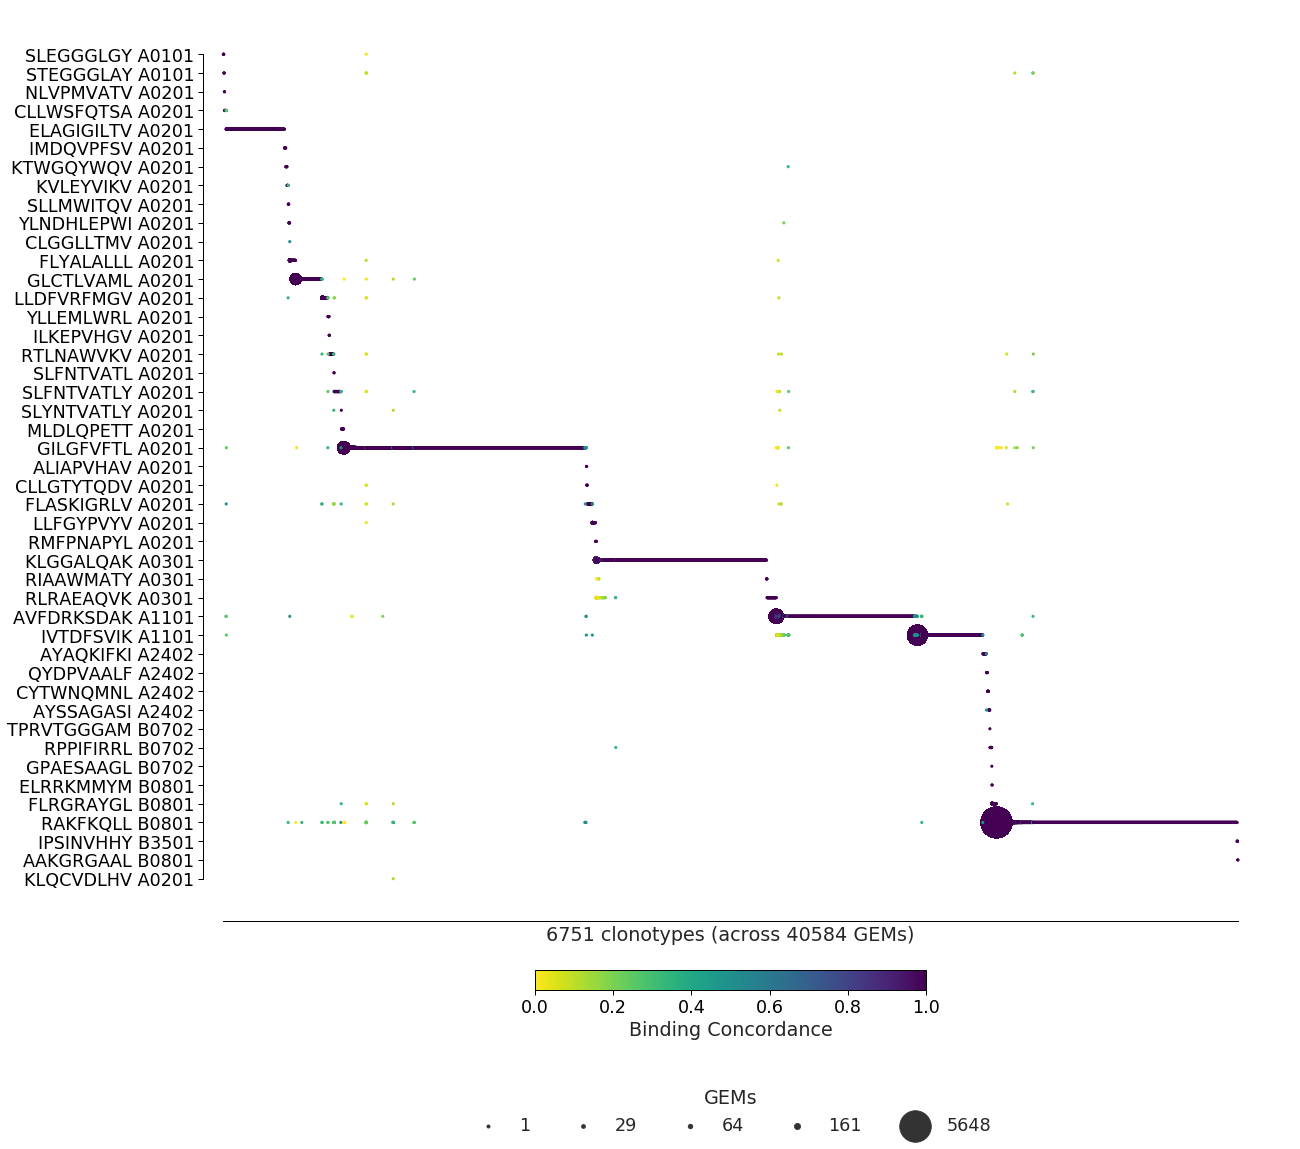

In [57]:
tmp = calc_binding_concordance(df[idx1 & idx3 & idx4].copy(), 'ct') # & idx5
filename='../experiments/exp10x/run1/plt/eval_filters/m.specificity.atrap.strict.png'
plot_specificity(filename, tmp, df.gems_per_specificity.max(), save=False)

In [49]:
tmp['bclass'] = np.where(tmp.binding_concordance > 0.5, 'normal','outlier')

In [61]:
tmp.loc[~(tmp.binding_concordance > 0.5),
        ['gem','gem_icon','ct','peptide_HLA','peptide_HLA_lst','cdr3_TRA','alpha_cdr3','cdr3_TRB','beta_cdr3','ct_pep','max_conc_pep', 'max_pep_in_lst',
         'peptide_HLA_icon','binding_concordance','max_conc', 'HLA_cd8']].sort_values(by='gem_icon') #.ct.nunique()

,gem,gem_icon,ct,peptide_HLA,peptide_HLA_lst,cdr3_TRA,alpha_cdr3,cdr3_TRB,beta_cdr3,ct_pep,max_conc_pep,max_pep_in_lst,peptide_HLA_icon,binding_concordance,max_conc,HLA_cd8
93,AAACGGGAGAAGATTC-1,AAACGGGAGAAGATTC-33,586,KLGGALQAK A0301,"[VTEHDTLLY A0101, LLDFVRFMGV A0201, SLFNTVATLY...",CAMREGSNDMRF,CAMREGSNDMRF,CASSIKGPFRTEAFF,CASSIKGPFRTEAFF,KLGGALQAK A0301,RAKFKQLL B0801,False,KLGGALQAK A0301,0.500000,0.500000,"[A0201, A1101, B3501]"
666,AACCGCGAGACAGACC-2,AACCGCGAGACAGACC-2,702,IVTDFSVIK A1101,"[NLVPMVATV A0201, KLQCVDLHV A0201, VTEHDTLLY A...",CAGVSTSGTYKYIF,CAGVSTSGTYKYIF,CASSQDGLAGDNEQFF,CASSQDGLAGDNEQFF,NaN,IVTDFSVIK A1101,True,IVTDFSVIK A1101,0.500000,0.500000,"[A0301, B0702, B5701]"
2123,ACACCGGTCCATGAAC-20,ACACCGGTCCATGAAC-23,97,AVFDRKSDAK A1101,"[RAKFKQLL B0801, AAKGRGAAL B0801, IVTDFSVIK A1...",CILWVAAGNKLTF,CILWVAAGNKLTF,CASSVRSSMNTEAFF,CASSVRSSMNTEAFF,KLGGALQAK A0301,KLGGALQAK A0301,True,AVFDRKSDAK A1101,0.025641,0.974359,"[A0201, A0101, B0801]"
3860,ACGGGTCCACGGCGTT-5,ACGGGTCCACGGCGTT-1,122,RAKFKQLL B0801,"[RLRAEAQVK A0301, IVTDFSVIK A1101, AVFDRKSDAK ...",CAAARMDSSYKLIF,CAMNPAWGGATNKLIF,CSASPGDYEQYF,CSASPGDYEQYF,NaN,KLGGALQAK A0301,True,RAKFKQLL B0801,0.037037,0.962963,"[A0201, A0101, B0801]"
3948,ACGTCAAGTATAGTAG-4,ACGTCAAGTATAGTAG-32,620,GLCTLVAML A0201,"[KVLEYVIKV A0201, GILGFVFTL A0201, RLRAEAQVK A...",CAGGNTGKLIF,CAGGNTGKLIF,CASSLGQGASQPQHF,CASSLGQGASQPQHF,NaN,KLGGALQAK A0301,True,GLCTLVAML A0201,0.500000,0.500000,"[A0201, A1101, B3501]"
5501,AGCCTAAAGAATTCCC-20,AGCCTAAAGAATTCCC-23,705,IVTDFSVIK A1101,"[IMDQVPFSV A0201, KLQCVDLHV A0201, AVFDRKSDAK ...",CAVRYGNNRLAF,CAVRYGNNRLAF,CASSSLGAREQFF,CASSSLGAREQFF,NaN,IVTDFSVIK A1101,True,IVTDFSVIK A1101,0.500000,0.500000,"[A0201, A0101, B0801]"
7517,ATCATGGGTAAATACG-13,ATCATGGGTAAATACG-31,503,GILGFVFTL A0201,"[CYTWNQMNL A2402, RIAAWMATY A0301, AVFDRKSDAK ...",CAFMKGAGGTSYGKLTF,CAFMKGAGGTSYGKLTF,CASSFSGNTGELFF,CASSFSGNTGELFF,NaN,RAKFKQLL B0801,True,GILGFVFTL A0201,0.500000,0.500000,"[A0201, A1101, B3501]"
9067,CAAGAAAGTGTGAAAT-23,CAAGAAAGTGTGAAAT-20,107,AVFDRKSDAK A1101,"[KTWGQYWQV A0201, IMDQVPFSV A0201, LLDFVRFMGV ...",CGAAGNMLTF,CGAAGNMLTF,CASGMTGLTSEQYF,CASGMTGLTSEQYF,NaN,KLGGALQAK A0301,True,AVFDRKSDAK A1101,0.060606,0.939394,"[A0201, A0101, B0801]"
10831,CAGCCGAGTTAGTGGG-36,CAGCCGAGTTAGTGGG-18,434,RAKFKQLL B0801,"[FLASKIGRLV A0201, RMFPNAPYL A0201, RIAAWMATY ...",CAASDGGSNYKLTF,CAASDGGSNYKLTF,CASSLTGQSQRVYGYTF,CASSLTGQSQRVYGYTF,NaN,KLGGALQAK A0301,True,RAKFKQLL B0801,0.333333,0.666667,"[A0201, A0101, B0801]"
12074,CATGGCGCAGTCGATT-3,CATGGCGCAGTCGATT-3,91,AVFDRKSDAK A1101,"[RIAAWMATY A0301, IVTDFSVIK A1101, KLGGALQAK A...",CAIGPGNMLTF,CAIGPGNMLTF,CSVDLEANYGYTF,CSVDLEANYGYTF,KLGGALQAK A0301,KLGGALQAK A0301,True,AVFDRKSDAK A1101,0.023810,0.976190,"[A2402, A2902, B3502, B4403]"


In [109]:
tmp.loc[(tmp.binding_concordance < 0.5) & (tmp.ct_pep.isna()),
        ['gem','ct','peptide_HLA','peptide_HLA_lst','cdr3_TRA','cdr3_TRB','ct_pep','max_conc_pep', 'max_pep_in_lst',
         'peptide_HLA_icon','binding_concordance','max_conc']].sort_values(by='ct') #.ct.nunique()

,gem,ct,peptide_HLA,peptide_HLA_lst,cdr3_TRA,cdr3_TRB,ct_pep,max_conc_pep,max_pep_in_lst,peptide_HLA_icon,binding_concordance,max_conc
130734,GTAGTCAAGGACGAAA-34-s1,113,IVTDFSVIK A1101,"[KLGGALQAK A0301, RLRAEAQVK A0301, RIAAWMATY A...",CALSEAYAGGTSYGKLTF,CASRTGNLNTEAFF,NaN,AVFDRKSDAK A1101,True,NaN,0.142857,0.857143
90102,CTGAAGTGTCTGGAGA-34-s2,1208,RAKFKQLL B0801,"[MLDLQPETT A0201, ELRRKMMYM B0801, SLEGGGLGY A...",CAASETSYDKVIF,CASSWGGGSHYGYTF,NaN,IVTDFSVIK A1101,False,NaN,0.333333,0.666667
97575,GAACGGATCAACACTG-13-s1,1220,IVTDFSVIK A1101,"[KTWGQYWQV A0201, SLLMWITQV A0201, LLDFVRFMGV ...",CAGHTGNQFYF,CASSLRDGSEAFF,NaN,RAKFKQLL B0801,False,NaN,0.400000,0.600000
159666,TCTGGAATCCATGAAC-2-s1,1220,IVTDFSVIK A1101,"[ILKEPVHGV A0201, KLQCVDLHV A0201, QYDPVAALF A...",CAGHTGNQFYF,CASSLRDGSEAFF,NaN,RAKFKQLL B0801,False,GILGFVFTL A0201,0.400000,0.600000
893,AAAGATGCAAGCTGAG-36-s1,137,IVTDFSVIK A1101,"[GPAESAAGL B0702, RLRAEAQVK A0301, AVFDRKSDAK ...",CILRPYSSASKIIF,CASSPVSQGANSGNTIYF,NaN,AVFDRKSDAK A1101,True,NaN,0.333333,0.666667
67062,CGAATGTCACATTTCT-39-s2,14567,FLASKIGRLV A0201,"[MLDLQPETT A0201, IVTDFSVIK A1101, AYAQKIFKI A...",CAVTRDDKIIF,CASSTDRAAQPQHF,NaN,SLFNTVATLY A0201,False,NaN,0.250000,0.500000
81921,CTACACCAGTAGTGCG-20-s2,14567,RAKFKQLL B0801,"[LLDFVRFMGV A0201, NLVPMVATV A0201, RLRAEAQVK ...",CAVTRDDKIIF,CASSTDRAAQPQHF,NaN,SLFNTVATLY A0201,False,RAKFKQLL B0801,0.250000,0.500000
131536,GTATTCTAGTGTCCAT-26-s1,22152,IVTDFSVIK A1101,"[ELAGIGILTV A0201, CLLWSFQTSA A0201, GILGFVFTL...",CADSGGGADGLTF,CASSWGGGSHYGYTF,NaN,RAKFKQLL B0801,False,NaN,0.250000,0.750000
86848,CTCGAGGTCGCATGGC-23-s2,22338,RAKFKQLL B0801,"[MLDLQPETT A0201, RLRAEAQVK A0301, RIAAWMATY A...",CAASETSYDKVIF,CASSIRSSYEQYF,NaN,GILGFVFTL A0201,False,RAKFKQLL B0801,0.333333,0.666667
152408,TCAGCAAGTGTGAAAT-14-s1,25603,AVFDRKSDAK A1101,"[VTEHDTLLY A0101, KVLEYVIKV A0201, NLVPMVATV A...",CAVGDNFNKFYF,CASSFSGNTGELFF,NaN,RAKFKQLL B0801,False,NaN,0.333333,0.666667


In [101]:
tmp.loc[(tmp.binding_concordance <= 0.5) & (tmp.ct_pep == tmp.max_conc_pep),
        ['gem','ct','peptide_HLA','peptide_HLA_lst','cdr3_TRA','cdr3_TRB','ct_pep','max_conc_pep',
         'max_pep_in_lst', 'peptide_HLA_icon','binding_concordance','max_conc']].apply(lambda row: row.peptide_HLA.split()[1] in row.ct_pep, axis=1).sum()

,gem,ct,peptide_HLA,peptide_HLA_lst,cdr3_TRA,cdr3_TRB,ct_pep,max_conc_pep,max_pep_in_lst,peptide_HLA_icon,binding_concordance,max_conc
168303,TGGCGCAAGCCCTAAT-30-s2,30369,GLCTLVAML A0201,"[FLASKIGRLV A0201, KLQCVDLHV A0201, MLDLQPETT ...",CAGSPSNTGKLIF,CASSARSSYEQYF,GILGFVFTL A0201,GILGFVFTL A0201,True,NaN,0.003448,0.996552
128669,GTAACGTCATAGACTC-14-s2,30697,RTLNAWVKV A0201,"[ILKEPVHGV A0201, RAKFKQLL B0801, RTLNAWVKV A0...",CAAPETSYDKVIF,CASSPGTSETGELFF,RAKFKQLL B0801,RAKFKQLL B0801,True,NaN,0.066667,0.933333
100161,GACCTGGAGTTCCACA-11-s2,685,GILGFVFTL A0201,"[YLNDHLEPWI A0201, RIAAWMATY A0301, CYTWNQMNL ...",CAASETSYDKVIF,CASSFSGNTGELFF,RAKFKQLL B0801,RAKFKQLL B0801,True,NaN,0.000354,0.999646
113925,GCGCCAAGTACATGTC-10-s2,685,GILGFVFTL A0201,"[QPRAPIRPI B0702, SLEGGGLGY A0101, RAKFKQLL B0...",CAASETSYDKVIF,CASSFSGNTGELFF,RAKFKQLL B0801,RAKFKQLL B0801,True,NaN,0.000354,0.999646
107318,GATTCAGCAGGGAGAG-14-s2,30743,GILGFVFTL A0201,"[KLGGALQAK A0301, AVFDRKSDAK A1101, QYDPVAALF ...",CAMTGSGGSNYKLTF,CSVGTGDYEQYF,RAKFKQLL B0801,RAKFKQLL B0801,True,NaN,0.058824,0.941176
...,...,...,...,...,...,...,...,...,...,...,...,...
31174,AGTGAGGCATCCGGGT-9-s2,30395,RAKFKQLL B0801,"[LLDFVRFMGV A0201, YLLEMLWRL A0201, RLRAEAQVK ...",CAGGGSQGNLIF,CASSTRSSYEQYF,GILGFVFTL A0201,GILGFVFTL A0201,True,NaN,0.006536,0.993464
67494,CGACCTTCAGCTGTGC-24-s2,495,RAKFKQLL B0801,"[KVAELVHFL A0201, LLDFVRFMGV A0201, CYTWNQMNL ...",CAGAGSQGNLIF,CASSIRSSYEQYF,GILGFVFTL A0201,GILGFVFTL A0201,True,NaN,0.003610,0.996390
139652,GTTCGGGCACTGTTAG-3-s2,30353,RAKFKQLL B0801,"[YLNDHLEPWI A0201, KLGGALQAK A0301, RIAAWMATY ...",CAVAKDLQNSGGGADGLTF,CASSARSSTEQYF,GILGFVFTL A0201,GILGFVFTL A0201,True,NaN,0.001667,0.998333
54314,CATCGAAGTACAGACG-28-s2,30349,RAKFKQLL B0801,"[IMDQVPFSV A0201, CLLGTYTQDV A0201, MLDLQPETT ...",CGTEYPNDYKLSF,CASSSGLVSNTGELFF,GLCTLVAML A0201,GLCTLVAML A0201,True,NaN,0.001332,0.998668


In [102]:
76-58

18

In [97]:
tmp.loc[(tmp.binding_concordance <= 0.5) & (~tmp.ct_pep.isna() & (tmp.ct_pep != tmp.max_conc_pep)),
        ['gem','ct','peptide_HLA','peptide_HLA_lst','cdr3_TRA','cdr3_TRB','ct_pep','max_conc_pep',
         'max_pep_in_lst','ct_pep_in_lst', 'peptide_HLA_icon','binding_concordance','max_conc']]#.ct_pep_in_lst.sum()

,gem,ct,peptide_HLA,peptide_HLA_lst,cdr3_TRA,cdr3_TRB,ct_pep,max_conc_pep,max_pep_in_lst,ct_pep_in_lst,peptide_HLA_icon,binding_concordance,max_conc
62609,CCTAAAGAGTCCTCCT-11-s2,30343,SLEGGGLGY A0101,"[RAKFKQLL B0801, KLGGALQAK A0301, SLEGGGLGY A0...",CAAKEGYSTLTF,CASSSTGGGEKDQPQHF,KLGGALQAK A0301,RAKFKQLL B0801,True,True,NaN,0.029412,0.235294
36476,ATCTGCCGTCAGAATA-20-s2,30343,STEGGGLAY A0101,"[RLRAEAQVK A0301, IVTDFSVIK A1101, AVFDRKSDAK ...",CAAKEGYSTLTF,CASSSTGGGEKDQPQHF,KLGGALQAK A0301,RAKFKQLL B0801,False,True,NaN,0.088235,0.235294
112311,GCGACCACAGCTTAAC-37-s2,30343,STEGGGLAY A0101,"[KTWGQYWQV A0201, KLGGALQAK A0301, AYSSAGASI A...",CAAKEGYSTLTF,CASSSTGGGEKDQPQHF,KLGGALQAK A0301,RAKFKQLL B0801,False,True,NaN,0.088235,0.235294
161343,TGACGGCCATGCCTTC-27-s2,30343,STEGGGLAY A0101,"[RAKFKQLL B0801, STEGGGLAY A0101]",CAAKEGYSTLTF,CASSSTGGGEKDQPQHF,KLGGALQAK A0301,RAKFKQLL B0801,True,False,NaN,0.088235,0.235294
134874,GTCTCGTTCGAACGGA-36-s2,30367,STEGGGLAY A0101,"[YLNDHLEPWI A0201, RIAAWMATY A0301, AVFDRKSDAK...",CAVSLSGGYNKLIF,CASSPAGGTDTQYF,KLGGALQAK A0301,RAKFKQLL B0801,False,True,NaN,0.333333,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54698,CATCGGGCATCCCACT-9-s2,30381,RAKFKQLL B0801,"[IVTDFSVIK A1101, KLGGALQAK A0301, RAKFKQLL B0...",CALLNRDDKIIF,CASSHLGGDRYMNEQFF,KLGGALQAK A0301,RAKFKQLL B0801,True,True,NaN,0.333333,0.333333
111174,GCATGTACATTCCTGC-16-s2,30472,RAKFKQLL B0801,"[SLLMWITQV A0201, LLDFVRFMGV A0201, YLNDHLEPWI...",CAMRSTGNQFYF,CASSQDPSRTYEQYF,KLGGALQAK A0301,RAKFKQLL B0801,True,True,NaN,0.333333,0.333333
124687,GGGAGATAGAGTACCG-33-s2,30411,RAKFKQLL B0801,"[ELAGIGILTV A0201, GILGFVFTL A0201, NLVPMVATV ...",CAASSGGTSYGKLTF,CASSPLWVAGGRETQYF,KLGGALQAK A0301,RAKFKQLL B0801,True,True,NaN,0.333333,0.333333
135713,GTGCAGCAGAAGATTC-4-s2,30366,RAKFKQLL B0801,"[KTWGQYWQV A0201, ELRRKMMYM B0801, STEGGGLAY A...",CILRDLNAGGTSYGKLTF,CASSEVVSTTYEQYF,KLGGALQAK A0301,RAKFKQLL B0801,True,True,NaN,0.333333,0.333333


In [90]:
266+76#+65

342

In [51]:
dct = tmp.groupby(['ct']).binding_concordance.max()
tmp['max_conc'] = tmp.ct.map(dct)

In [52]:
dct = tmp[tmp.max_conc == tmp.binding_concordance].set_index('ct').peptide_HLA.to_dict()
tmp['max_conc_pep'] = tmp.ct.map(dct)

In [53]:
tmp['max_pep_in_lst'] = tmp.apply(lambda row: row.max_conc_pep in row.peptide_HLA_lst, axis=1)
tmp['ct_pep_in_lst'] = tmp.apply(lambda row: row.ct_pep in row.peptide_HLA_lst, axis=1)

/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/matplotlib/colorbar.py:214: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


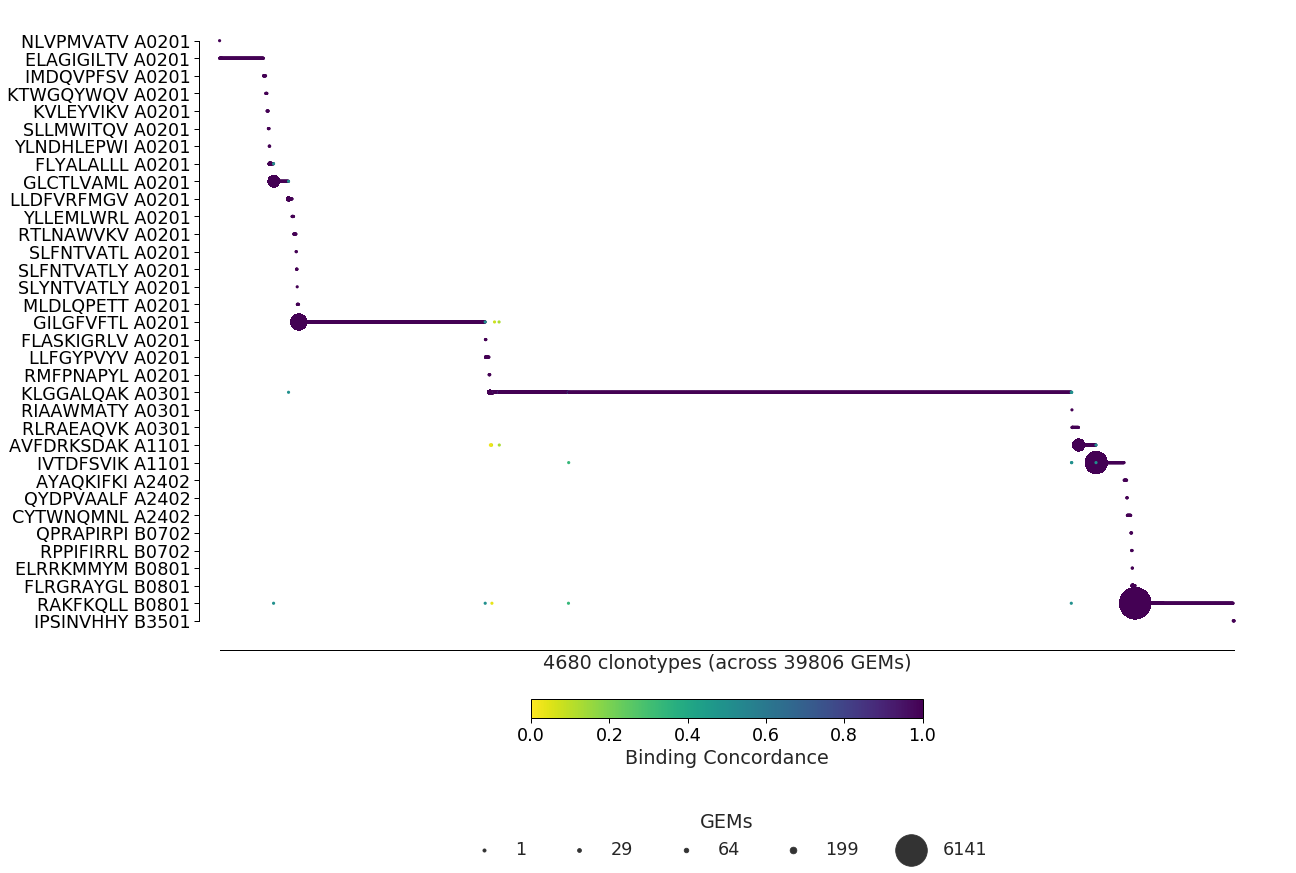

In [48]:
tmp = calc_binding_concordance(df_icon.copy(), 'ct') 
filename = 'lol' #'../experiments/exp10x/run1/plt/eval_filters/m.specificity.icon.png'
plot_specificity(filename, tmp, df.gems_per_specificity.max(), save=False)

In [71]:
df[idx1 & idx3 & idx4].peptide_HLA.value_counts() #.groupby('peptide_HLA').ct.nunique()

RAKFKQLL B0801      20020
GILGFVFTL A0201      8943
IVTDFSVIK A1101      3364
AVFDRKSDAK A1101     2979
KLGGALQAK A0301      2303
GLCTLVAML A0201      1659
ELAGIGILTV A0201      396
LLDFVRFMGV A0201      180
FLYALALLL A0201       179
RLRAEAQVK A0301       120
SLFNTVATLY A0201       63
FLRGRAYGL B0801        62
FLASKIGRLV A0201       50
RTLNAWVKV A0201        38
LLFGYPVYV A0201        37
AYAQKIFKI A2402        24
MLDLQPETT A0201        15
RPPIFIRRL B0702        13
CLLWSFQTSA A0201       12
KTWGQYWQV A0201         9
IMDQVPFSV A0201         9
STEGGGLAY A0101         9
AYSSAGASI A2402         9
KVLEYVIKV A0201         8
RIAAWMATY A0301         8
YLLEMLWRL A0201         8
CYTWNQMNL A2402         8
CLLGTYTQDV A0201        7
YLNDHLEPWI A0201        7
QYDPVAALF A2402         6
RMFPNAPYL A0201         5
SLEGGGLGY A0101         5
SLLMWITQV A0201         4
IPSINVHHY B3501         4
SLYNTVATLY A0201        4
ILKEPVHGV A0201         3
AAKGRGAAL B0801         2
ALIAPVHAV A0201         2
ELRRKMMYM B0

In [67]:
df_icon.groupby('peptide_HLA_icon').ct.nunique()

peptide_HLA_icon
AVFDRKSDAK A1101      85
AYAQKIFKI A2402       12
CYTWNQMNL A2402       16
ELAGIGILTV A0201     202
ELRRKMMYM B0801        2
FLASKIGRLV A0201       3
FLRGRAYGL B0801       12
FLYALALLL A0201       18
GILGFVFTL A0201      863
GLCTLVAML A0201       69
IMDQVPFSV A0201       10
IPSINVHHY B3501        5
IVTDFSVIK A1101      133
KLGGALQAK A0301     2685
KTWGQYWQV A0201        6
KVLEYVIKV A0201        6
LLDFVRFMGV A0201      16
LLFGYPVYV A0201       14
MLDLQPETT A0201        6
NLVPMVATV A0201        1
QPRAPIRPI B0702        4
QYDPVAALF A2402        3
RAKFKQLL B0801       457
RIAAWMATY A0301        1
RLRAEAQVK A0301       30
RMFPNAPYL A0201        4
RPPIFIRRL B0702        2
RTLNAWVKV A0201       11
SLFNTVATL A0201        2
SLFNTVATLY A0201       3
SLLMWITQV A0201        4
SLYNTVATLY A0201       1
YLLEMLWRL A0201        7
YLNDHLEPWI A0201       3
Name: ct, dtype: int64

In [57]:
tmp.loc[tmp.VDJdb_check == False, ['ct','peptide_HLA','peptide_HLA_lst','VDJdb_pep','VDJdb_check']].dropna()

,ct,peptide_HLA,peptide_HLA_lst,VDJdb_pep,VDJdb_check
38942,8,FLYALALLL A0201,[FLYALALLL A0201],['GILGFVFTL'],False
63201,8,RPPIFIRRL B0702,"[CLLGTYTQDV A0201, AVFDRKSDAK A1101, RPPIFIRRL...",['GILGFVFTL'],False
128333,8,RPPIFIRRL B0702,"[SLLMWITQV A0201, KLGGALQAK A0301, RPPIFIRRL B...",['GILGFVFTL'],False
75917,51038,RPPIFIRRL B0702,"[SLFNTVATLY A0201, RPPIFIRRL B0702]",['SLFNTVATL'],False
213,8,KLGGALQAK A0301,"[RIAAWMATY A0301, AAKGRGAAL B0801, IVTDFSVIK A...",['GILGFVFTL'],False
...,...,...,...,...,...
102023,8,FLASKIGRLV A0201,"[LLMGTLGIVC A0201, KLGGALQAK A0301, IVTDFSVIK ...",['GILGFVFTL'],False
156923,8,AYSSAGASI A2402,"[KTWGQYWQV A0201, NLVPMVATV A0201, QPRAPIRPI B...",['GILGFVFTL'],False
102537,30353,IVTDFSVIK A1101,"[ILKEPVHGV A0201, CYTWNQMNL A2402, LLFGYPVYV A...",['GILGFVFTL'],False
121587,30353,RAKFKQLL B0801,"[YLNDHLEPWI A0201, KLGGALQAK A0301, RIAAWMATY ...",['GILGFVFTL'],False


In [110]:
auc_df.rename(columns={'filtering':'filters'}, inplace=True)
auc_df['percent'] = auc_df.value * 100
dct = auc_df.groupby(['filters','variable']).percent.mean()
auc_df['counts'] = auc_df.set_index(['filters','variable']).index.map(dct)

In [111]:
#auc_df = auc_df[auc_df.filters != 'no negatives'].copy()

In [112]:
auc_df.filters = np.where(auc_df.filters == 'is functional cell', 'is viable cell', auc_df.filters)

In [113]:
test_df = pd.concat([plt_df, auc_df])

In [114]:
test_df = test_df[test_df.variable.isin(['GEMs','accuracy','avg. conc.','AUC','AUC 0.1'])]

In [115]:
test_df['tmp'] = np.where(test_df.variable == 'AUC', test_df['counts'], test_df['percent'])

In [116]:
#tmp = test_df.drop_duplicates(subset=['variable','filters']).groupby(['filters'], sort=False).tmp.mean().to_frame().reset_index()
#tmp['variable'] = 'summary'
#tmp['counts'] = tmp.tmp
#tmp['percent'] = tmp.tmp
#tmp

In [117]:
#test_df = pd.concat([test_df, tmp])

In [118]:
test_df = test_df[test_df.variable.isin(['GEMs','accuracy','avg. conc.','AUC'])].copy() #,'summary'

In [119]:
#test_df = plt_df.copy() # 10x without AUC :(

In [120]:
test_df.variable = np.where(test_df.variable == 'clonotypes','clones',test_df.variable)
test_df.variable = np.where(test_df.variable == 'avg. conc.','avg.\nconc.',test_df.variable)

In [121]:
cnt = test_df.groupby('filters', sort=False).counts.unique()
cnt_flat = [x for y in cnt.to_list() for x in y]

In [122]:
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})
sns.set_context("paper",font_scale=2)

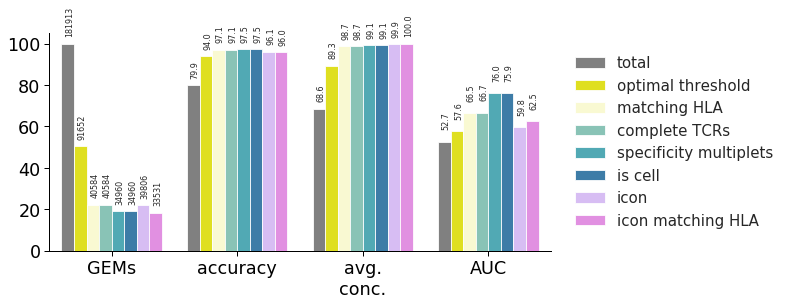

In [124]:
plt.figure(figsize=(9,4))#7
ax = sns.barplot(data=test_df, hue='filters',y='percent',x='variable', ci='sd',
                 palette=palette+palette_icon) #['grey','#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']
for p, c in zip(ax.patches, cnt_flat):
    yoff = 7
    if type(c) == int:
        ax.annotate("%d" % c, xy=(p.get_x()+p.get_width()/2, p.get_height()), #p.get_width()
            xytext=(2, yoff), textcoords='offset points', ha="center", va="bottom", size=8, rotation=90)
    else:
        if decimal.Decimal(str(c)).as_tuple().exponent < -2:
            yoff = 12
        ax.annotate("%.1f" % round(c,1), xy=(p.get_x()+p.get_width()/2, p.get_height()), #p.get_width()
                xytext=(2, yoff), textcoords='offset points', ha="center", va="bottom", size=8, rotation=90) #
    
#ax.legend(title=False, frameon=False, bbox_to_anchor=(0.5,-0.2), loc='upper center') #
ax.legend(title=False, frameon=False, bbox_to_anchor=(1.02,0.5), loc='center left', prop={'size': 15})
sns.despine()#trim=True, offset={'left':10}
plt.xlabel('')
plt.ylabel('')
#plt.savefig('../experiments/exp13/run3/plt/eval_filters/sco.%s.png'%filter_set, bbox_inches='tight',dpi=300)
plt.savefig('../experiments/exp10x/run1/plt/eval_filters/m.sco.icon.%s.png'%filter_set, bbox_inches='tight',dpi=300)
plt.show()